# Simulating 2D Epileptor model

In [1]:
import os
import sys
import time
import errno


import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns


In [2]:
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import pystan

In [4]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [20]:
plt.style.use('seaborn-talk');

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [6]:
cwd = os.getcwd()
cwd

'/home/meysam/Epileptor/Epileptor2D'

# Generate Synthetic Data

In [24]:
Nt, Tend, sigma = 1000,100.0, 1e-1

In [25]:
dt=Tend/Nt
print ('dt:', dt)

dt: 0.1


In [26]:
t0=0.0
Ts = arange(dt,Tend+dt,dt)
#Tend = array([(Nt+1)*dt] , dtype='float32')

In [27]:
tau0=10.
I1=3.1

In [28]:
eta_true=-1.5

In [29]:
x, z= np.zeros(Nt), np.zeros(Nt)
xs, zs= np.zeros(Nt), np.zeros(Nt)

In [30]:
x_init, z_init=-2.5, 3.5

In [31]:
x[0],z[0]=x_init, z_init

In [32]:
for t in range(Nt-1):
    dx =1.0 - x[t]**3 - 2.0*x[t]**2 - z[t] + I1   
    dz =(1.0/tau0)*(4*(x[t]-eta_true) - z[t])
    x[t+1]=(x[t] + dt * dx + sqrt(dt) *sigma * randn())
    z[t+1]=(z[t] + dt * dz + sqrt(dt) *sigma * randn())

In [33]:
xs,zs = x+sigma*randn(x.size), array(z)+sigma*randn(z.size)

In [34]:
obs= array([xs, zs]).transpose() 

In [35]:
ts = dt*np.r_[:xs.shape[0]]

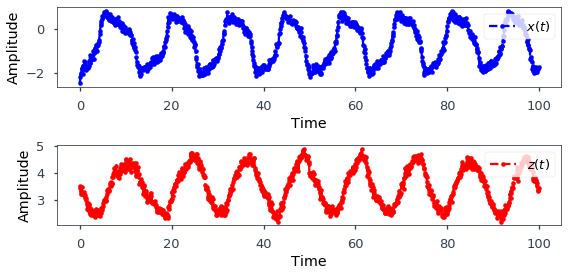

In [38]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(ts,(obs[:,0]) , '--b.', label='$x(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.subplot(212)
plt.plot(ts, obs[:,1], '--r.', label='$z(t)$')
plt.xlabel('Time'); ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.show()

In [43]:
f_decim=1
obs_decim, ts_decim= obs[::f_decim], ts[::f_decim]
Ts_decim = np.arange(dt,Tend+dt,dt*f_decim)

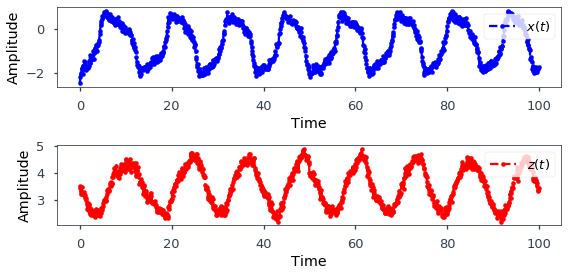

In [44]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(ts_decim, obs_decim[:,0], '--b.', label='$x(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.subplot(212)
plt.plot(ts_decim, obs_decim[:,1], '--r.', label='$z(t)$')
plt.xlabel('Time'); ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.show()

In [45]:
def nullclines(X,Y, eta, tau0):   
    dX =  1.0 - X**3 - 2.0*X**2 - Y + I1 
    dY =  (1.0/tau0)*(4*(X-eta) - Y)
    contour(X, Y, dX, 0, colors='r')
    contour(X, Y, dY, 0, colors='b') 

In [46]:
def root_fuc(roots, eta, tau0):   
    x = empty(1)
    z = empty(1)
    F = empty(2)
    x = roots[0]
    z = roots[1]
    F[0] =1.0 - x**3 - 2.0*x**2 - z + I1 
    F[1] =(1.0/tau0)*(4*(x-eta) - z)
    return F

In [47]:
rGuess=array([[-1.,3.]])
true_roots = fsolve(root_fuc,rGuess, args=(eta_true, tau0))

print('true_roots:', true_roots)

true_roots: [-0.6014927   3.59402919]


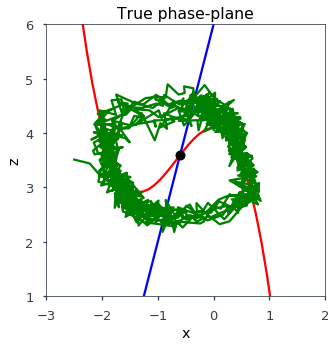

In [50]:
X, Z = mgrid[-5.0:5.0:100j, 0.0:10.0:100j]

plt.figure(figsize=(5, 5))
plt.plot(obs_decim[:,0], obs_decim[:,1], 'g')
nullclines(X,Z,  eta_true, tau0)
plt.plot(true_roots[0],true_roots[1] , marker="o", markersize=10, color='k')
plt.xlabel('x'); plt.ylabel('z'); 
plt.title('True phase-plane')
plt.xlim((-3,2)), plt.ylim((1,6))
plt.show()

In [51]:
nt=obs_decim[:,0].shape[0]
dt_decim=ts_decim[1]-ts_decim[0]
dT_decim=Ts_decim[1]-Ts_decim[0]

dt_decim, dT_decim

(0.1, 0.1)

In [52]:
xs_decim=array([obs_decim[:,0]]).transpose()
zs_decim=array([obs_decim[:,1]]).transpose()

xs_decim.shape, obs_decim[:,0].shape

((1000, 1), (1000,))

In [53]:
xs_norm=2*(obs_decim[:,0]-min(obs_decim[:,0]))/(max(obs_decim[:,0])-min(obs_decim[:,0]))-1.0
zs_norm=2*(obs_decim[:,1]-min(obs_decim[:,1]))/(max(obs_decim[:,1])-min(obs_decim[:,1]))-1.0

In [54]:
! mkdir -p  data_input_files

In [57]:
data_iput_filename=str('data_input_epileptor')

In [58]:
data_iput_dict= {
    'nt': nt, 'dt': dt_decim, 't0': t0,  'Ts': Ts, 
    'xs': obs_decim[:,0], 'zs': obs_decim[:,1], 
    'xs_norm': xs_norm, 'zs_norm': zs_norm, 
    'x_init': x_init, 'z_init': z_init, 
    'tau0': tau0,  'I1': I1, 'eta_true':eta_true,
    'xlim': np.r_[-5.0, 5.0],'zlim': np.r_[0.0, 10.0],
}

In [60]:
nd=[]
npz = {'nd': nd}
npz.update(data_iput_dict)
np.savez(cwd+'/data_input_files/'+ str(data_iput_filename) +'.R.npz', **npz)
np.savez(cwd+'/data_input_files/'+ str(data_iput_filename) +'.npz', **npz)
pystan.stan_rdump(data_iput_dict, cwd+'/data_input_files/' + str(data_iput_filename)+ '.R')